## Lab 11 Transformers - Multi Head Attention

În acest tutorial, vom discuta despre una dintre cele mai influente arhitecturi din ultimii ani: modelul Transformer. De la publicarea lucrării [Attention Is All You Need](https://arxiv.org/abs/1706.03762) de către Vaswani și colaboratorii săi în 2017, arhitectura Transformer a continuat să fundamenteze modele neurale în multe domenii, cel mai important în procesarea limbajului natural (NLP). Transformerele cu un număr mare de parametri pot genera [eseuri](https://www.theguardian.com/commentisfree/2020/sep/08/robot-wrote-this-article-gpt-3) lungi și convingătoare și au deschis noi domenii de aplicare ale inteligenței artificiale. Deoarece entuziasmul pentru arhitectura Transformer pare să nu se diminueze în următorii ani, este important să înțelegem cum funcționează și să o implementăm noi înșine, lucru pe care îl vom face în acest notebook.

In [1]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR100
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/lab12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

C:\Users\Renata\AppData\Local\Temp\ipykernel_24072\1304589977.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Device: cpu


<Figure size 640x480 with 0 Axes>

Arhitectura Transformer

În prima parte a acestui notebook, vom implementa arhitectura Transformer de la zero. Deși această arhitectură este atât de populară încât există deja un modul Pytorch, `nn.Transformer` ([documentație](https://pytorch.org/docs/stable/generated/torch.nn.Transformer.html)) și un [tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html) despre cum să îl utilizăm pentru predicția următorului token, vom implementa noi înșine această arhitectură pentru a înțelege cele mai mici detalii.

Desigur, există multe alte tutoriale despre mecanismul de atenție și despre Transformeri. Mai jos, am inclus câteva resurse care merită explorate dacă ești interesat de acest subiect și ai dori o altă perspectivă după ce parcurgi acest material:

- [Transformer: O arhitectură neuronală nouă pentru înțelegerea limbajului (Jakob Uszkoreit, 2017)](https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html) - Postarea originală pe blogul Google despre lucrarea Transformer, cu accent pe aplicațiile în traducerea automată.
- [The Illustrated Transformer (Jay Alammar, 2018)](http://jalammar.github.io/illustrated-transformer/) - Un articol popular și excelent care explică intuitiv arhitectura Transformer cu multe vizualizări atractive. Accentul este pus pe NLP.
- [Attention? Attention! (Lilian Weng, 2018)](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) - Un articol care rezumă mecanismele de atenție în mai multe domenii, inclusiv viziunea computerizată.
- [Illustrated: Self-Attention (Raimi Karim, 2019)](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a) - O vizualizare detaliată a pașilor procesului de auto-atenție. Recomandat dacă explicațiile de mai jos sunt prea abstracte pentru tine.
- [The Transformer family (Lilian Weng, 2020)](https://lilianweng.github.io/lil-log/2020/04/07/the-transformer-family.html) - Un articol detaliat care trece în revistă mai multe variante ale Transformerilor, dincolo de cel original.


### Ce este mecanismul de atenție?

Mecanismul de atenție descrie un grup recent de straturi în rețelele neuronale care a atras mult interes în ultimii ani, mai ales în sarcinile legate de secvențe. Există multe definiții diferite ale "atenției" în literatură, dar cea pe care o vom folosi aici este următoarea: _mecanismul de atenție descrie o medie ponderată a elementelor (secvenței), cu ponderile calculate dinamic pe baza unei interogări (query) și a cheilor elementelor_. Ce înseamnă mai exact asta? Obiectivul este să calculăm o medie a caracteristicilor mai multor elemente. Totuși, în loc să ponderăm fiecare element în mod egal, dorim să le ponderăm în funcție de valorile lor reale. Cu alte cuvinte, dorim să decidem dinamic asupra căror intrări să "acordăm atenție" mai mult decât altora. În mod specific, un mecanism de atenție are de obicei patru părți pe care trebuie să le specificăm:

* **Query (Interogare)**: Interogarea este un vector de caracteristici care descrie ce căutăm în secvență, adică la ce am dori să acordăm atenție.
* **Keys (Chei)**: Pentru fiecare element de intrare, avem o cheie, care este din nou un vector de caracteristici. Acest vector descrie aproximativ ce "oferă" elementul sau când ar putea fi important. Cheile ar trebui proiectate astfel încât să putem identifica elementele asupra cărora dorim să acordăm atenție pe baza interogării.
* **Values (Valori)**: Pentru fiecare element de intrare, avem și un vector de valori. Acest vector de caracteristici este cel asupra căruia dorim să calculăm media.
* **Funcție de scor**: Pentru a evalua asupra căror elemente dorim să acordăm atenție, trebuie să specificăm o funcție de scor $f_{attn}$. Funcția de scor ia ca intrare interogarea și o cheie și returnează scorul/ponderea de atenție pentru perechea interogare-cheie. Este de obicei implementată prin metrici simple de similaritate, precum un produs scalar, sau un mic MLP.

Ponderile mediei sunt calculate printr-un softmax peste toate rezultatele funcției de scor. Astfel, atribuim o pondere mai mare acelor vectori de valori ale căror chei corespund cel mai bine interogării. Dacă încercăm să descriem acest proces în pseudo-matematică, putem scrie:

$$
\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i
$$

Vizual, putem arăta atenția aplicată asupra unei secvențe de cuvinte astfel:

<center width="100%" style="padding:25px"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/attention_example.svg?raw=1" width="750px"></center>

Pentru fiecare cuvânt, avem un vector de cheie și unul de valoare. Interogarea este comparată cu toate cheile printr-o funcție de scor (în acest caz, produsul scalar) pentru a determina ponderile. Softmax-ul nu este vizualizat pentru simplificare. În final, vectorii de valori ai tuturor cuvintelor sunt mediați utilizând ponderile de atenție.

Majoritatea mecanismelor de atenție diferă prin ceea ce utilizează ca interogări, cum sunt definite cheile și vectorii de valori, și ce funcție de scor este folosită. Atenția aplicată în arhitectura Transformer se numește **auto-atenție (self-attention)**. În auto-atenție, fiecare element al secvenței oferă o cheie, o valoare și o interogare. Pentru fiecare element, aplicăm un strat de atenție în care, pe baza interogării sale, verificăm similaritatea tuturor cheilor elementelor secvenței și returnăm un vector de valori mediat diferit pentru fiecare element. Vom detalia acum mai specific implementarea mecanismului de atenție, care în cazul Transformer este atenția cu produs scalar scalat.


### Atenția cu Produs Scalar Scalată (Scaled Dot Product Attention)

Conceptul de bază din spatele auto-atenției este atenția cu produs scalar scalată. Obiectivul nostru este să avem un mecanism de atenție prin care orice element dintr-o secvență să poată acorda atenție oricărui alt element, menținând în același timp eficiența de calcul. Atenția cu produs scalar primește ca intrare un set de interogări $Q\in\mathbb{R}^{T\times d_k}$, chei $K\in\mathbb{R}^{T\times d_k}$ și valori $V\in\mathbb{R}^{T\times d_v}$, unde $T$ este lungimea secvenței, iar $d_k$ și $d_v$ sunt dimensiunile ascunse pentru interogări/chei și valori, respectiv. Pentru simplitate, neglijăm dimensiunea batch-ului deocamdată. Valoarea atenției de la elementul $i$ la $j$ este bazată pe similaritatea dintre interogarea $Q_i$ și cheia $K_j$, folosind produsul scalar ca metrică de similaritate. Matematic, calculăm atenția cu produs scalar astfel:

$$\text{Attention}(Q,K,V)=\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Multiplicarea matricială $QK^T$ efectuează produsul scalar pentru fiecare pereche posibilă de interogări și chei, rezultând o matrice cu forma $T\times T$. Fiecare rând reprezintă logiturile de atenție pentru un element specific $i$ către toate celelalte elemente din secvență. Pe aceste valori aplicăm un softmax și multiplicăm cu vectorul de valori pentru a obține o medie ponderată (ponderile fiind determinate de atenție). O altă perspectivă asupra acestui mecanism de atenție este oferită de graficul de calcul vizualizat mai jos (credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/scaled_dot_product_attn.svg?raw=1" width="210px"></center>

Un aspect pe care nu l-am discutat încă este factorul de scalare $1/\sqrt{d_k}$. Acest factor de scalare este crucial pentru a menține o varianță adecvată a valorilor de atenție după inițializare. Reamintiți-vă că inițializăm straturile noastre cu intenția de a avea o varianță egală în tot modelul, așa că $Q$ și $K$ ar putea avea o varianță apropiată de $1$. Totuși, efectuarea unui produs scalar între doi vectori cu o varianță $\sigma^2$ rezultă într-un scalar cu o varianță de $d_k$ ori mai mare:

$$
q_i \sim \mathcal{N}(0,\sigma^2), k_i \sim \mathcal{N}(0,\sigma^2) \to \text{Var}\left(\sum_{i=1}^{d_k} q_i\cdot k_i\right) = \sigma^4\cdot d_k
$$

Dacă nu reducem varianța înapoi la $\sim\sigma^2$, softmax-ul asupra logiturilor se va satura deja la $1$ pentru un element aleatoriu și la $0$ pentru toate celelalte. Gradienții prin softmax vor fi aproape zero, ceea ce împiedică învățarea corectă a parametrilor. Rețineți că factorul suplimentar $\sigma^2$, adică având $\sigma^4$ în loc de $\sigma^2$, de obicei nu reprezintă o problemă, deoarece păstrăm varianța originală $\sigma^2$ apropiată de $1$.

Blocul `Mask (opt.)` din diagramă reprezintă mascarea opțională a anumitor intrări din matricea de atenție. Acest lucru este folosit, de exemplu, dacă stivuim mai multe secvențe cu lungimi diferite într-un batch. Pentru a beneficia în continuare de paralelizarea din PyTorch, completăm propozițiile la aceeași lungime și mascăm token-urile de completare în timpul calculului valorilor de atenție. De obicei, acest lucru se face setând logiturile de atenție respective la o valoare foarte mică.

După ce am discutat detaliile blocului de atenție cu produs scalar scalat, putem scrie mai jos o funcție care calculează caracteristicile de ieșire, date tripletul de interogări, chei și valori:


In [2]:
def scaled_dot_product(q, k, v, mask=None):
    """
    Scaled Dot-Product Attention computation.

    Inputs:
        q - Query tensor of shape (batch_size, num_heads, seq_length, head_dim)
        k - Key tensor of shape (batch_size, num_heads, seq_length, head_dim)
        v - Value tensor of shape (batch_size, num_heads, seq_length, head_dim)
        mask - Optional mask tensor of shape (batch_size, 1, seq_length, seq_length) or broadcastable

    Outputs:
        values - Output tensor of shape (batch_size, num_heads, seq_length, head_dim)
        attention - Attention weights of shape (batch_size, num_heads, seq_length, seq_length)

    TODO 1.1 Compute attention logits:
    - Perform a matrix multiplication between `q` and the transpose of `k` along the last two dimensions:
        `attn_logits = torch.matmul(q, k.transpose(-2, -1))`
    - The resulting shape should be (batch_size, num_heads, seq_length, seq_length).

    TODO 1.2. Scale the attention logits:
    - Divide `attn_logits` by the square root of `head_dim` (i.e., `math.sqrt(d_k)` where `d_k` is the last dimension of `q`).

    TODO 1.3. Apply masking (if `mask` is provided):
    - Use `attn_logits.masked_fill(mask == 0, -9e15)` to set attention logits to a very large negative value where the mask is 0.
    - Ensure the mask shape is broadcastable with `attn_logits`.

    TODO 1.4. Compute the attention weights:
    - Apply softmax to the scaled (and masked, if applicable) logits along the last dimension (`dim=-1`).

    TODO 1.5. Compute the final output values:
    - Perform a matrix multiplication between the attention weights and the value tensor `v`.

    TODO 1.6. Return the results:
    - Return the computed `values` tensor (shape: (batch_size, num_heads, seq_length, head_dim)).
    - Also return the `attention` weights (shape: (batch_size, num_heads, seq_length, seq_length)).

    Hints:
    - Use `torch.matmul` for matrix multiplications.
    - Use `F.softmax` for the softmax operation.
    - Use `mask` only if it is not `None` and ensure compatibility with `attn_logits` shape.
    """

    attn_logits = torch.matmul(q, k.transpose(-2, -1))

    d_k=q.size(-1)
    attn_logits=attn_logits/math.sqrt(d_k)

    if mask is not None:
      attn_logits=attn_logits.masked_fill(mask == 0, -9e15)

    attention = F.softmax(attn_logits, dim=-1)

    values=torch.matmul(attention, v)

    return values, attention

Rețineți că codul nostru de mai sus suportă orice dimensiune suplimentară în fața lungimii secvenței, astfel încât să îl putem utiliza și pentru batch-uri. Totuși, pentru o înțelegere mai bună, să generăm câteva interogări, chei și vectori de valori aleatori și să calculăm ieșirile atenției:

In [3]:
seq_len, d_k = 3, 2
pl.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


In [4]:
def test_scaled_dot_product_student():
    # Define hardcoded inputs
    q = torch.tensor([[ 0.3367,  0.1288],
                      [ 0.2345,  0.2303],
                      [-1.1229, -0.1863]])
    k = torch.tensor([[ 2.2082, -0.6380],
                      [ 0.4617,  0.2674],
                      [ 0.5349,  0.8094]])
    v = torch.tensor([[ 1.1103, -1.6898],
                      [-0.9890,  0.9580],
                      [ 1.3221,  0.8172]])

    # Define expected outputs
    expected_values = torch.tensor([[ 0.5698, -0.1520],
                                     [ 0.5379, -0.0265],
                                     [ 0.2246,  0.5556]])
    expected_attention = torch.tensor([[0.4028, 0.2886, 0.3086],
                                        [0.3538, 0.3069, 0.3393],
                                        [0.1303, 0.4630, 0.4067]])

    # Calculate attention using student's implementation
    values_student, attention_student = scaled_dot_product(q, k, v)

    # Compare outputs with expected values using torch.allclose()
    assert torch.allclose(values_student, expected_values, atol=1e-4)
    assert torch.allclose(attention_student, expected_attention, atol=1e-4)
    print("TODO 1 Test Passed!")

In [5]:
test_scaled_dot_product_student()

TODO 1 Test Passed!


### Atenția Multi-Head

Atenția cu produs scalar scalat permite unei rețele să acorde atenție unei secvențe. Totuși, de multe ori există mai multe aspecte diferite asupra cărora un element al secvenței dorește să acorde atenție, iar o singură medie ponderată nu este o opțiune potrivită. De aceea extindem mecanismele de atenție la multiple heads, adică multiple triplete interogare-cheie-valoare aplicate pe aceleași caracteristici. Specific, având o matrice de interogări, chei și valori, le transformăm în $h$ sub-interogări, sub-chei și sub-valori, pe care le trecem independent prin mecanismul de atenție cu produs scalar scalat. Ulterior, concatenăm aceste heads și le combinăm cu o matrice finală de ponderi. Matematic, putem exprima această operație astfel:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{unde } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

Acest strat este denumit strat de atenție Multi-Head, având parametrii antrenabili $W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$, $W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$ și $W^{O}\in\mathbb{R}^{h\cdot d_v\times d_{out}}$ ($D$ fiind dimensiunea de intrare). Exprimat într-un grafic computațional, putem vizualiza acest mecanism astfel (credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/multihead_attention.svg?raw=1" width="230px"></center>

Cum aplicăm un strat de atenție Multi-Head într-o rețea neuronală, unde nu avem vectori arbitari de interogare, cheie și valoare ca intrare? Privind graficul computațional de mai sus, o implementare simplă dar eficientă este să setăm harta de caracteristici curentă dintr-o rețea neuronală, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, ca $Q$, $K$ și $V$ ($B$ fiind dimensiunea batch-ului, $T$ lungimea secvenței, $d_{\text{model}}$ dimensiunea ascunsă a lui $X$). Matricile consecutive de ponderi $W^{Q}$, $W^{K}$ și $W^{V}$ pot transforma $X$ în vectori de caracteristici corespunzători care reprezintă interogările, cheile și valorile intrării. Folosind această abordare, putem implementa modulul de Atenție Multi-Head mai jos.


In [6]:
# Helper function to support different mask shapes.
# Output shape supports (batch_size, number of heads, seq length, seq length)
# If 2D: broadcasted over batch size and number of heads
# If 3D: broadcasted over number of heads
# If 4D: leave as is
def expand_mask(mask):
    assert mask.ndim >= 2, "Mask must be at least 2-dimensional with seq_length x seq_length"
    if mask.ndim == 3:
        mask = mask.unsqueeze(1)
    while mask.ndim < 4:
        mask = mask.unsqueeze(0)
    return mask

In [7]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        """
        Forward pass of the MultiheadAttention module.

        Inputs:
            x - Input tensor of shape (batch_size, seq_length, input_dim)
            mask - Optional mask tensor of shape (seq_length, seq_length) or broadcastable
            return_attention - Boolean indicating whether to return attention weights along with the output

        Outputs:
            o - Output tensor of shape (batch_size, seq_length, embed_dim)
            attention (optional) - Attention weights of shape (batch_size, num_heads, seq_length, seq_length) if `return_attention=True`

        TODOs:
        TODO 2.1. Project the input tensor `x` to produce Q, K, and V:
        - Use `self.qkv_proj` to compute a single tensor of shape (batch_size, seq_length, 3*embed_dim).
        - Split this tensor into Q, K, and V tensors of shape (batch_size, seq_length, embed_dim).


        TODO 2.2. Reshape and permute Q, K, and V for multi-head processing:
        - Reshape the tensors to shape (batch_size, seq_length, num_heads, head_dim), where `head_dim = embed_dim // num_heads`.
        - Permute the tensors to shape (batch_size, num_heads, seq_length, head_dim) for computation.

        TODO 2.3. Compute the scaled dot-product attention:
        - Use the helper function `scaled_dot_product(q, k, v, mask=mask)` to compute:
            - `values` of shape (batch_size, num_heads, seq_length, head_dim)
            - `attention` weights of shape (batch_size, num_heads, seq_length, seq_length) (if `mask` is applied).
        - The mask can be expanded using the `expand_mask` function, if provided.

        TODO 2.4. Reshape and permute the attention output:
        - Permute the `values` tensor back to shape (batch_size, seq_length, num_heads, head_dim).
        - Reshape it to shape (batch_size, seq_length, embed_dim) for the output projection.

        TODO 2.5. Apply the output projection:
        - Use `self.o_proj` to project the reshaped `values` to the final output tensor of shape (batch_size, seq_length, embed_dim).

        TODO 2.6. Return the outputs:
        - If `return_attention` is `True`, return both the output tensor and the attention weights.
        - Otherwise, return only the output tensor.

        Hint:
        - Use the `qkv.chunk(3, dim=-1)` method to split Q, K, and V from the concatenated tensor.
        - Ensure the input-output shapes align throughout the computation.
        """

        qkv=self.qkv_proj(x)

        qkv=qkv.reshape(x.size(0), x.size(1), self.num_heads, 3*self.head_dim).permute(0,2,1,3)

        q,k,v=qkv.chunk(3,dim=-1)

        if mask is not None:
          mask = expand_mask(mask)

        values, attention = scaled_dot_product(q,k,v, mask=mask)

        values = values.permute(0, 2, 1, 3).reshape(x.size(0), x.size(1), self.embed_dim)


        o = self.o_proj(values)

        if return_attention:
          return o, attention

        return o

O caracteristică crucială a atenției multi-head este că este permutabil-ecuativă față de intrările sale. Asta înseamnă că, dacă schimbăm două elemente de intrare din secvență, de exemplu $X_1\leftrightarrow X_2$ (neglijând dimensiunea batch-ului pentru moment), ieșirea va fi exact aceeași, cu excepția elementelor 1 și 2 schimbate între ele. Astfel, atenția multi-head privește intrarea nu ca o secvență, ci ca un set de elemente. Această proprietate face ca blocul de atenție multi-head și arhitectura Transformer să fie atât de puternice și aplicabile pe scară largă! Dar ce se întâmplă dacă ordinea intrării este de fapt importantă pentru rezolvarea unei sarcini, cum ar fi modelarea limbajului? Răspunsul este să codificăm poziția în caracteristicile de intrare, lucru pe care îl vom analiza mai detaliat mai târziu (subiectul _Codificări poziționale_ mai jos).

Înainte de a trece la crearea arhitecturii Transformer, putem compara operația de auto-atenție cu alte straturi comune pentru date secvențiale: convoluțiile și rețelele neuronale recurente. Mai jos puteți găsi un tabel realizat de [Vaswani et al. (2017)](https://arxiv.org/abs/1706.03762) care prezintă complexitatea per strat, numărul de operații secvențiale și lungimea maximă a căii. Complexitatea este măsurată prin limita superioară a numărului de operații necesare, în timp ce lungimea maximă a căii reprezintă numărul maxim de pași pe care un semnal de avans sau de propagare inversă trebuie să-i parcurgă pentru a ajunge la orice altă poziție. Cu cât această lungime este mai mică, cu atât mai bine pot semnalele gradientului să se propage pentru dependențe pe termen lung. Să analizăm tabelul de mai jos:

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/comparison_conv_rnn.svg?raw=1" width="600px"></center>

$n$ este lungimea secvenței, $d$ este dimensiunea reprezentării, iar $k$ este dimensiunea kernelului convoluțiilor. Spre deosebire de rețelele neuronale recurente, stratul de auto-atenție poate paraleliza toate operațiile sale, făcându-l mult mai rapid pentru secvențe mai scurte. Totuși, atunci când lungimea secvenței depășește dimensiunea ascunsă, auto-atenția devine mai costisitoare decât RNN-urile. O modalitate de a reduce costul computațional pentru secvențe lungi este restricționarea auto-atenției la un vecinaj de intrări asupra cărora să acorde atenție, notat cu $r$. Cu toate acestea, recent s-a lucrat mult la arhitecturi Transformer mai eficiente, care încă permit dependențe pe termen lung. Puteți găsi o prezentare generală a acestor lucrări în articolul realizat de [Tay et al. (2020)](https://arxiv.org/abs/2009.06732), dacă sunteți interesați.

### Encoder-ul Transformer

În continuare, vom analiza cum să aplicăm blocul de atenție multi-head în cadrul arhitecturii Transformer. Inițial, modelul Transformer a fost conceput pentru traducerea automată. Astfel, are o structură encoder-decoder în care encoder-ul primește ca intrare propoziția în limba originală și generează o reprezentare bazată pe atenție. Pe de altă parte, decoder-ul analizează informația codificată și generează propoziția tradusă într-un mod autoregresiv, similar cu o RNN standard. Deși această structură este extrem de utilă pentru sarcini de tip Secvență-la-Secvență care necesită decodare autoregresivă, ne vom concentra aici pe partea de encoder. Multe progrese în procesarea limbajului natural (NLP) au fost realizate folosind modele Transformer bazate doar pe encoder (exemple includ familia [BERT](https://arxiv.org/abs/1810.04805), [Vision Transformer](https://arxiv.org/abs/2010.11929) și altele). În cadrul tutorialului nostru, ne vom concentra în principal pe partea de encoder. Dacă înțelegeți arhitectura encoder-ului, implementarea decoder-ului reprezintă un pas mic suplimentar. Arhitectura completă a Transformer-ului arată astfel (credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)):

<center width="100%"><img src="https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial6/transformer_architecture.svg?raw=1" width="400px"></center>

Encoder-ul constă în $N$ blocuri identice aplicate în secvență. Având ca intrare $x$, aceasta este mai întâi trecută printr-un bloc de atenție multi-head, așa cum am implementat mai sus. Ieșirea este adăugată la intrarea originală utilizând o conexiune reziduală, iar suma este trecută printr-o Normalizare de Strat (Layer Normalization). Per ansamblu, se calculează $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$ ($x$ fiind $Q$, $K$ și $V$ pentru stratul de atenție). Conexiunea reziduală este crucială în arhitectura Transformer din două motive:

1. Similar cu ResNet-urile, Transformer-ele sunt proiectate să fie foarte adânci. Unele modele conțin mai mult de 24 de blocuri în encoder. Astfel, conexiunile reziduale sunt esențiale pentru a permite un flux neted al gradientului prin model.
2. Fără conexiunea reziduală, informația despre secvența originală se pierde. Amintiți-vă că stratul de atenție Multi-Head ignoră poziția elementelor într-o secvență și poate învăța aceasta doar pe baza caracteristicilor de intrare. Eliminarea conexiunilor reziduale ar însemna pierderea acestei informații după primul strat de atenție (după inițializare), iar cu un vector de interogare și cheie inițializat aleatoriu, ieșirile pentru poziția $i$ nu ar avea nicio legătură cu intrarea originală. Toate ieșirile stratului de atenție ar reprezenta probabil informații similare, iar modelul nu ar putea distinge ce informații provin de la fiecare element de intrare. O alternativă la conexiunea reziduală ar fi fixarea unui head pentru a se concentra pe intrarea sa originală, dar aceasta este foarte ineficientă și nu beneficiază de îmbunătățirea fluxului gradientului.

Normalizarea de Strat joacă, de asemenea, un rol important în arhitectura Transformer, deoarece permite o antrenare mai rapidă și oferă o ușoară regularizare. În plus, asigură că caracteristicile au o magnitudine similară între elementele secvenței. Nu utilizăm Normalizarea pe Batch deoarece aceasta depinde de dimensiunea batch-ului, care este adesea mică în cazul Transformer-elor (necesită multă memorie GPU), iar BatchNorm s-a dovedit a performa slab în limbaj, deoarece caracteristicile cuvintelor tind să aibă o varianță mult mai mare (există multe cuvinte foarte rare care trebuie considerate pentru o estimare bună a distribuției).

Pe lângă atenția multi-head, un mic feed-forward network complet conectat este adăugat modelului, aplicat separat și identic pe fiecare poziție. Specific, modelul folosește un MLP de tip Linear$\to$ReLU$\to$Linear. Transformarea completă, inclusiv conexiunea reziduală, poate fi exprimată astfel:  

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

Acest MLP adaugă complexitate suplimentară modelului și permite transformări pe fiecare element al secvenței separat. Vă puteți imagina că aceasta permite modelului să "prelucreze" noile informații adăugate de atenția multi-head anterioară și să le pregătească pentru următorul bloc de atenție. De obicei, dimensiunea interioară a MLP-ului este de 2-8$\times$ mai mare decât $d_{\text{model}}$, adică dimensiunea intrării originale $x$. Avantajul general al unui strat mai larg în locul unui MLP îngust, multi-strat, este execuția mai rapidă și paralelizabilă.

În final, după ce am analizat toate părțile arhitecturii encoder-ului, putem începe implementarea acestuia mai jos. Vom începe prin implementarea unui singur bloc de encoder. Pe lângă straturile descrise mai sus, vom adăuga dropout în cadrul MLP-ului și pe ieșirea MLP-ului și a atenției multi-head pentru regularizare.


In [8]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        """
        Forward pass of the EncoderBlock.

        Inputs:
            x - Input tensor of shape (seq_len, batch_size, input_dim)
            mask - Optional mask tensor of shape (seq_len, seq_len) to prevent attention to certain positions

        Outputs:
            Output tensor of the same shape as input (seq_len, batch_size, input_dim)

        TODOs:
        TODO3.1. Implement the self-attention mechanism:
        - Use `self.self_attn` to compute the attention output.
        - Pass the input tensor `x` and the optional `mask` as arguments.
        - The output shape of the attention mechanism should match `x` (seq_len, batch_size, input_dim).

        TODO3.2. Add residual connection:
        - Add the attention output to the original input tensor `x`.
        - Use the `self.dropout` layer on the attention output before adding it.

        TODO3.3. Apply layer normalization:
        - Use `self.norm1` to normalize the resulting tensor after the residual connection.

        TODO3.4. Implement the feedforward network:
        - Pass the normalized tensor through `self.linear_net` to compute the output of the feedforward network.
        - The feedforward network processes the tensor of shape (seq_len, batch_size, input_dim) and returns a tensor of the same shape.

        TODO3.5. Add another residual connection:
        - Add the output of the feedforward network to its input.
        - Use `self.dropout` on the feedforward network output before adding it.

        TODO3.6. Apply the second layer normalization:
        - Use `self.norm2` to normalize the final output tensor.

        Make sure to preserve the input-output shapes throughout the forward method.
        """

        attn_output = self.self_attn(x, mask=mask)

        x = x + self.dropout(attn_output)

        x = self.norm1(x)

        feed_forward = self.linear_net(x)

        x = x + self.dropout(feed_forward)

        x = self.norm2(x)
        return x

Pe baza acestui bloc, putem implementa un modul pentru encoder-ul complet al Transformer-ului. Pe lângă o funcție `forward` care iterează prin secvența de blocuri de encoder, oferim și o funcție numită `get_attention_maps`. Ideea acestei funcții este să returneze probabilitățile de atenție pentru toate blocurile de atenție multi-head din encoder. Acest lucru ne ajută să înțelegem și, într-un fel, să explicăm modelul. Totuși, probabilitățile de atenție ar trebui interpretate cu prudență, deoarece nu reflectă neapărat adevărata interpretare a modelului (există o serie de lucrări despre acest subiect, inclusiv [Attention is not Explanation](https://arxiv.org/abs/1902.10186) și [Attention is not not Explanation](https://arxiv.org/abs/1908.04626)).

In [9]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x)
        return attention_maps

### Codificare pozițională

Am discutat anterior că blocul de atenție multi-head este permutabil-ecuativ și nu poate distinge dacă o intrare apare înaintea alteia într-o secvență. Totuși, în sarcini precum înțelegerea limbajului, poziția este importantă pentru interpretarea cuvintelor de intrare. Informația despre poziție poate fi adăugată prin caracteristicile de intrare. Am putea învăța o reprezentare pentru fiecare poziție posibilă, dar aceasta nu s-ar generaliza la o lungime dinamică a secvenței de intrare. Prin urmare, opțiunea mai bună este să folosim modele de caracteristici pe care rețeaua le poate identifica și generaliza la secvențe mai lungi. Modelul specific ales de Vaswani et al. constă în funcții sinusoidale și cosinusoidale de frecvențe diferite, astfel:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{dacă}\hspace{3mm} i \text{ mod } 2=0\\\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{altfel}\\\\
\end{cases}
$$

$PE_{(pos,i)}$ reprezintă codificarea pozițională la poziția $pos$ în secvență, și dimensiunea ascunsă $i$. Aceste valori, concatenate pentru toate dimensiunile ascunse, sunt adăugate caracteristicilor de intrare originale (în vizualizarea Transformer de mai sus, vezi "Positional encoding") și constituie informația despre poziție. Distincția se face între dimensiunile ascunse pare ($i \text{ mod } 2=0$) și impare ($i \text{ mod } 2=1$), unde aplicăm respectiv funcția sinus/cosinus. Intuiția din spatele acestei codificări este că poți reprezenta $PE_{(pos+k,:)}$ ca o funcție liniară a lui $PE_{(pos,:)}$, ceea ce ar putea permite modelului să analizeze ușor pozițiile relative. Lungimile de undă din dimensiunile diferite variază între $2\pi$ și $10000\cdot 2\pi$.

Codificarea pozițională este implementată mai jos. Codul este preluat din [tutorialul PyTorch](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model) despre Transformeri în NLP și ajustat pentru scopurile noastre.

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

*Pentru* a înțelege codificarea pozițională, o putem vizualiza mai jos. Vom genera o imagine a codificării poziționale pe dimensiunea ascunsă și poziția într-o secvență. Fiecare pixel reprezintă astfel modificarea caracteristicii de intrare pe care o realizăm pentru a codifica o anumită poziție. Să procedăm mai jos.

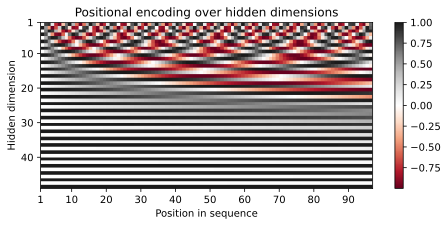

In [11]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

Așa cum putem observa, modelele dintre dimensiunile ascunse $1$ și $2$ diferă doar prin unghiul de start. Lungimea de undă este $2\pi$, deci repetarea apare după poziția $6$. Dimensiunile ascunse $2$ și $3$ au aproximativ de două ori lungimea de undă.

### Încălzirea ratei de învățare

O tehnică frecvent utilizată pentru antrenarea unui Transformer este încălzirea ratei de învățare. Aceasta înseamnă că creștem treptat rata de învățare de la 0 până la rata specificată inițial, în primele câteva iterații. Astfel, începem procesul de învățare încet, în loc să facem pași foarte mari de la început. De fapt, antrenarea unui Transformer profund fără încălzirea ratei de învățare poate face ca modelul să diverge și să obțină performanțe mult mai slabe la antrenare și testare. Pentru mai multe informatii studiati graficul realizat de [Liu et al. (2019)](https://arxiv.org/pdf/1908.03265.pdf) care compară Adam-vanilla (i.e., Adam fără încălzire) cu Adam cu încălzire.

In [12]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

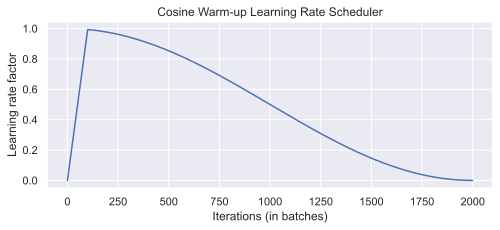

In [13]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4,4))
optimizer = optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8,3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

În primele 100 de iterații, creștem factorul ratei de învățare de la 0 la 1, în timp ce pentru toate iterațiile ulterioare îl reducem folosind unda cosinusoidală. Implementări predefinite ale acestui scheduler pot fi găsite în biblioteca populară NLP Transformer [huggingface](https://huggingface.co/transformers/main_classes/optimizer_schedules.html?highlight=cosine#transformers.get_cosine_schedule_with_warmup).

### Modul PyTorch Lightning

În final, putem integra arhitectura Transformer într-un modul PyTorch Lightning. Vom implementa un șablon pentru un clasificator bazat pe encoder-ul Transformer. Astfel, avem o ieșire de predicție per element al secvenței. Dacă am avea nevoie de un clasificator pentru întreaga secvență, abordarea obișnuită este să adăugăm un token suplimentar `[CLS]` în secvență, care să reprezinte token-ul de clasificare. Totuși, aici ne concentrăm pe sarcini în care avem o ieșire per element.

Pe lângă arhitectura Transformer, adăugăm o rețea mică de intrare (care mapează dimensiunile de intrare la dimensiunile modelului), codificarea pozițională și o rețea de ieșire (care transformă codificările de ieșire în predicții). Adăugăm, de asemenea, scheduler-ul pentru rata de învățare, care face un pas la fiecare iterație în loc de o dată pe epocă. Acest lucru este necesar pentru încălzirea și scăderea lină cosinusoidală. Pașii pentru antrenare, validare și testare sunt lăsați goi pentru moment și vor fi completați pentru modelele noastre specifice sarcinii.

In [14]:
class TransformerPredictor(pl.LightningModule):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, lr, warmup, max_iters, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            lr - Learning rate in the optimizer
            warmup - Number of warmup steps. Usually between 50 and 500
            max_iters - Number of maximum iterations the model is trained for. This is needed for the CosineWarmup scheduler
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=self.hparams.num_layers,
                                              input_dim=self.hparams.model_dim,
                                              dim_feedforward=2*self.hparams.model_dim,
                                              num_heads=self.hparams.num_heads,
                                              dropout=self.hparams.dropout)
        # Output classifier per sequence lement
        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)

        # Apply lr scheduler per step
        lr_scheduler = CosineWarmupScheduler(optimizer,
                                             warmup=self.hparams.warmup,
                                             max_iters=self.hparams.max_iters)
        return [optimizer], [{'scheduler': lr_scheduler, 'interval': 'step'}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError

## Experimente

După finalizarea implementării arhitecturii Transformer, putem începe să experimentăm și să o aplicăm pe diverse sarcini. În acest notebook, ne vom concentra pe două sarcini: traducerea paralelă Secvență-la-Secvență și detectarea anomaliilor într-un set. Cele două sarcini se concentrează pe proprietăți diferite ale arhitecturii Transformer, pe care le vom analiza mai jos.

### Sequence-to-sequence

O sarcină Sequence-to-sequence reprezintă o sarcină în care atât intrarea _cât și_ ieșirea sunt secvențe, nu neapărat de aceeași lungime. Sarcini populare în acest domeniu includ traducerea automată și sumarizarea. Pentru acestea, de obicei avem un encoder Transformer pentru interpretarea secvenței de intrare și un decoder pentru generarea ieșirii într-un mod autoregresiv. Totuși, aici vom reveni la o sarcină mult mai simplă și vom utiliza doar encoder-ul. Având o secvență de $N$ numere între $0$ și $M$, sarcina este să inversăm secvența de intrare. În notația Numpy, dacă intrarea este $x$, ieșirea ar trebui să fie $x$[::-1]. Deși această sarcină pare foarte simplă, RNN-urile pot avea dificultăți din cauza dependențelor pe termen lung necesare. Transformer-ele sunt construite pentru a sprijini astfel de dependențe și, prin urmare, ne așteptăm să funcționeze foarte bine.

Mai întâi, să creăm o clasă pentru dataset mai jos.

In [15]:
class ReverseDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        self.size = size

        self.data = torch.randint(self.num_categories, size=(self.size, self.seq_len))

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        inp_data = self.data[idx]
        labels = torch.flip(inp_data, dims=(0,))
        return inp_data, labels

Creăm un număr arbitrar de secvențe aleatoare de numere între 0 și `num_categories-1`. Eticheta este pur și simplu tensorul inversat pe dimensiunea secvenței. Putem crea mai jos data loaders corespunzătoare.

In [16]:
dataset = partial(ReverseDataset, 10, 16)
train_loader = data.DataLoader(dataset(50000), batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(dataset(1000), batch_size=128)
test_loader  = data.DataLoader(dataset(10000), batch_size=128)

Un sample arbitrar din dataset:

In [17]:
inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)

Input data: tensor([9, 6, 2, 0, 6, 2, 7, 9, 7, 3, 3, 4, 3, 7, 0, 9])
Labels:     tensor([9, 0, 7, 3, 4, 3, 3, 7, 9, 7, 2, 6, 0, 2, 6, 9])


În timpul antrenării, trecem secvența de intrare prin encoder-ul Transformer și prezicem ieșirea pentru fiecare token de intrare. Folosim pierderea standard Cross-Entropy pentru a realiza acest lucru. Fiecare număr este reprezentat ca un vector one-hot. Rețineți că reprezentarea categoriilor ca scalari simpli reduce extrem de mult expresivitatea modelului, deoarece $0$ și $1$ nu sunt mai apropiate decât $0$ și $9$ în exemplul nostru. O alternativă la un vector one-hot este utilizarea unui vector de embedding antrenabil, oferit de modulul PyTorch `nn.Embedding`. Totuși, utilizarea unui vector one-hot cu un strat linear suplimentar, ca în cazul nostru, are același efect ca un strat de embedding (`self.input_net` mapează vectorul one-hot la un vector dens, unde fiecare rând al matricei de greutăți reprezintă embedding-ul pentru o categorie specifică).

Pentru a implementa dinamica antrenării, creăm o nouă clasă care moștenește `TransformerPredictor` și suprascrie funcțiile pentru pașii de antrenare, validare și testare.

In [18]:
class ReversePredictor(TransformerPredictor):

    def _calculate_loss(self, batch, mode="train"):
        # Fetch data and transform categories to one-hot vectors
        inp_data, labels = batch
        inp_data = F.one_hot(inp_data, num_classes=self.hparams.num_classes).float()

        # Perform prediction and calculate loss and accuracy
        preds = self.forward(inp_data, add_positional_encoding=True)
        loss = F.cross_entropy(preds.view(-1,preds.size(-1)), labels.view(-1))
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        # Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

În final, putem crea o funcție de antrenare similară cu cea pe care am văzut-o în Tutorialul 5 pentru PyTorch Lightning. Creăm un obiect `pl.Trainer`, care rulează pentru $N$ epoci, loghează în TensorBoard și salvează cel mai bun model bazat pe validare. Ulterior, testăm modelele noastre pe setul de testare. Un parametru suplimentar pe care îl transmitem aici trainer-ului este `gradient_clip_val`. Acesta taie norma gradientelor pentru toți parametrii înainte de a face un pas cu optimizatorul și previne modelul să diverge dacă obținem gradienti foarte mari, de exemplu, pe suprafețe ascuțite de pierdere (consultați numeroasele articole bune despre gradient clipping, precum [DeepAI glossary](https://deepai.org/machine-learning-glossary-and-terms/gradient-clipping)). Pentru Transformeri, gradient clipping poate ajuta la stabilizarea suplimentară a antrenării în primele iterații și ulterior. În PyTorch simplu, puteți aplica gradient clipping prin `torch.nn.utils.clip_grad_norm_(...)` (vezi [documentația](https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html#torch.nn.utils.clip_grad_norm_)). Valoarea de tăiere este de obicei între 0.5 și 10, în funcție de cât de agresiv doriți să reduceți gradientele mari. După ce am explicat acest lucru, să implementăm funcția de antrenare:

In [19]:
def train_reverse(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    root_dir = os.path.join(CHECKPOINT_PATH, "ReverseTask")
    os.makedirs(root_dir, exist_ok=True)
    trainer = pl.Trainer(default_root_dir=root_dir,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=10,
                         gradient_clip_val=5)
    trainer.logger._default_hp_metric = None # Optional logging argument that we don't need

    model = ReversePredictor(max_iters=trainer.max_epochs*len(train_loader), **kwargs)
    trainer.fit(model, train_loader, val_loader)

    # Test best model on validation and test set
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    model = model.to(device)
    return model, result

În final, putem antrena modelul. În această configurare, vom folosi un singur bloc de encoder și un singur head în cadrul Multi-Head Attention. Această alegere este făcută datorită simplității sarcinii, iar în acest caz, atenția poate fi interpretată ca o "explicație" a predicțiilor (comparativ cu lucrările menționate mai sus care abordează Transformeri adânci).

In [20]:
reverse_model, reverse_result = train_reverse(input_dim=train_loader.dataset.num_categories,
                                              model_dim=32,
                                              num_heads=1,
                                              num_classes=train_loader.dataset.num_categories,
                                              num_layers=1,
                                              dropout=0.0,
                                              lr=5e-4,
                                              warmup=50)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name                | Type               | Params | Mode 
-------------------------------------------------------------------
0 | input_net           | Sequential         | 352    | train
1 | positional_encoding | PositionalEncoding | 0      | train
2 | transformer         | TransformerEncoder | 8.5 K  | train
3 | output_net          | Sequential         | 1.4 K  | train
-------------------------------------------------------------------
10.3 K    Trainable params
0         Non-trainable params
10.3 K    Total params
0.041     Total estimated model params size (MB)
24        Modules in train mode
0         Modules in eval mode


C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 390/390 [00:10<00:00, 36.43it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 390/390 [00:10<00:00, 36.42it/s, v_num=0]

C:\Users\Renata\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 79/79 [00:00<00:00, 82.29it/s]


Avertismentul din PyTorch Lightning referitor la numărul de workeri poate fi ignorat pentru moment. Deoarece setul de date este atât de simplu, iar metoda `__getitem__` este finalizată într-un timp neglijabil, nu avem nevoie de subprocese pentru a ne furniza datele (de fapt, un număr mai mare de workeri poate încetini antrenarea din cauza supraîncărcării comunicării între procese/threads). Mai întâi, să afișăm rezultatele:

In [21]:
print(f"Val accuracy:  {(100.0 * reverse_result['val_acc']):4.2f}%")
print(f"Test accuracy: {(100.0 * reverse_result['test_acc']):4.2f}%")

Val accuracy:  100.00%
Test accuracy: 100.00%


Așa cum ne-am fi așteptat, Transformer-ul poate rezolva corect sarcina. Totuși, cum arată atenția în cadrul blocului de Multi-Head Attention pentru o intrare arbitrară? Să încercăm să o vizualizăm mai jos.

In [22]:
data_input, labels = next(iter(val_loader))
inp_data = F.one_hot(data_input, num_classes=reverse_model.hparams.num_classes).float()
inp_data = inp_data.to(device)
attention_maps = reverse_model.get_attention_maps(inp_data)

Obiectul `attention_maps` este o listă de lungime $N$, unde $N$ este numărul de straturi. Fiecare element este un tensor de formă [Batch, Heads, SeqLen, SeqLen], lucru pe care îl putem verifica mai jos.

In [23]:
attention_maps[0].shape

torch.Size([128, 1, 16, 16])

În continuare, vom scrie o funcție de graficare care primește ca intrare secvențele, hărțile de atenție și un indice care indică pentru care element din batch dorim să vizualizăm harta de atenție. Vom crea un grafic în care, pe rânduri, avem straturile diferite, iar pe coloane, afișăm head-urile diferite. Rețineți că softmax-ul a fost aplicat separat pentru fiecare rând.

In [24]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data = np.arange(attn_maps[0][idx].shape[-1])
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    for row in range(num_layers):
        for column in range(num_heads):
            ax[row][column].imshow(attn_maps[row][column], origin='lower', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

În final, putem reprezenta grafic harta de atenție a Transformer-ului nostru antrenat pe sarcina de inversare:

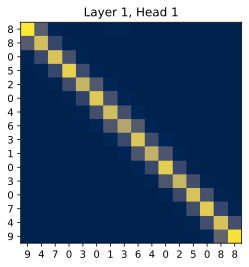

In [25]:
plot_attention_maps(data_input, attention_maps, idx=0)

Modelul a învățat să acorde atenție token-ului care se află pe indexul inversat al său. Prin urmare, face exact ceea ce am intenționat să facă. Observăm totuși că acordă o anumită atenție și valorilor apropiate de indexul inversat. Acest lucru se întâmplă deoarece modelul nu are nevoie de o atenție perfectă și strictă pentru a rezolva această problemă, ci este suficient cu această hartă de atenție aproximativă și zgomotoasă. Indicii apropiați sunt cauzați de similaritatea codificării poziționale, lucru pe care l-am intenționat și cu codificarea pozițională.

## Concluzie

În acest tutorial, am analizat mai îndeaproape stratul de atenție Multi-Head, care utilizează un produs scalar scalat între interogări (queries) și chei (keys) pentru a găsi corelații și similarități între elementele de intrare. Arhitectura Transformer se bazează pe stratul de atenție Multi-Head și aplică mai multe astfel de straturi într-un bloc similar ResNet. Transformer-ul este o arhitectură foarte importantă și recentă, care poate fi aplicată pe multe sarcini și seturi de date. Deși este cel mai bine cunoscut pentru succesul său în NLP, este utilizabil în multe alte domenii. Am văzut aplicarea sa pe sarcini de tip secvență-la-secvență și pe detectarea anomaliilor într-un set. Proprietatea sa de a fi permutabil-ecuativ, în absența codificărilor poziționale, îi permite să se generalizeze în multe contexte. Prin urmare, este important să cunoaștem arhitectura, dar și posibilele sale probleme, cum ar fi problema gradientului în primele iterații, rezolvată prin încălzirea ratei de învățare.

Dacă sunteți interesați să continuați studiul arhitecturii Transformer, vă rugăm să consultați articolele de blog enumerate la începutul acestui tutorial.